# RTM — Phase 1b: Bayesian Logistic Inference (v1b)

Model:

logit(p_i) = α + β_E * E_std_i + β_H * H_std_i  
Y_i ~ Bernoulli(p_i)

Goal:
- Recover synthetic parameters
- Validate inference stability
- Compute posterior ranking metrics

## 0) Setup

In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Resolve repo root
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name.lower() == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

assert (REPO_ROOT / "src").exists()

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.rtm.io_hazard import load_rtm_pluvial_v1_buildings

OUT_DIR = REPO_ROOT / "outputs" / "rtm" / "inference_v1b"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Repo root:", REPO_ROOT)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Repo root: C:\Users\C.Price\Habnetic\resilient-housing-bayes


## 1) Load outcome + inputs

In [2]:
# --- Load outcome ---
Y_PATH = REPO_ROOT / "outputs" / "rtm" / "outcomes" / "Y_damage_v1b.parquet"
assert Y_PATH.exists(), "Outcome file missing."
Y_df = pd.read_parquet(Y_PATH)

# --- Load exposure ---
E_PATH = REPO_ROOT / "outputs" / "rtm" / "water_exposure_Ehat_v0.parquet"
E_df = pd.read_parquet(E_PATH)[["bldg_id", "E_hat"]]

# --- Load hazard ---
haz_df = load_rtm_pluvial_v1_buildings()

# --- Merge full dataset ---
df_full = Y_df.merge(E_df, on="bldg_id", validate="one_to_one")
df_full = df_full.merge(haz_df, on="bldg_id", validate="one_to_one")

print("Full rows:", len(df_full))

# --- Subsample for inference ---
N = 5000
df = df_full.sample(N, random_state=42).reset_index(drop=True)

print("Subsample rows:", len(df))
df.head()

Full rows: 221324
Subsample rows: 5000


,bldg_id,Y_damage_v1b,p_true,outcome_src,outcome_version,seed,alpha,beta_E,beta_H,E_hat,H_pluvial_v1_mm
0,754660,0,0.040459,synthetic,v1b,42,-2.944439,1.0,0.6,0.352021,25.460167
1,1089288,0,0.086687,synthetic,v1b,42,-2.944439,1.0,0.6,0.265809,25.757582
2,181051,0,0.064814,synthetic,v1b,42,-2.944439,1.0,0.6,0.452870,25.582821
3,1060547,0,0.048044,synthetic,v1b,42,-2.944439,1.0,0.6,-0.326680,25.781500
4,1027296,0,0.089988,synthetic,v1b,42,-2.944439,1.0,0.6,0.367937,25.731373


## 2) Standardize predictors

In [3]:
def zscore(x: pd.Series) -> pd.Series:
    mu = x.mean()
    sd = x.std(ddof=1)
    return (x - mu) / sd

df["E_std"] = zscore(df["E_hat"])
df["H_std"] = zscore(df["H_pluvial_v1_mm"])

print("E_std mean/std:", df["E_std"].mean(), df["E_std"].std(ddof=1))
print("H_std mean/std:", df["H_std"].mean(), df["H_std"].std(ddof=1))

E_std mean/std: 2.842170943040401e-18 1.0
H_std mean/std: -5.561066e-06 0.99999994


## 3) Bayesian Logistic Model

In [4]:
coords = {"obs_id": np.arange(len(df))}

with pm.Model(coords=coords) as model:

    E_data = pm.Data("E_std", df["E_std"].values, dims="obs_id")
    H_data = pm.Data("H_std", df["H_std"].values, dims="obs_id")

    alpha = pm.Normal("alpha", mu=0, sigma=2.5)
    beta_E = pm.Normal("beta_E", mu=0, sigma=2.5)
    beta_H = pm.Normal("beta_H", mu=0, sigma=2.5)

    logit_p = alpha + beta_E * E_data + beta_H * H_data
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p), dims="obs_id")

    Y_obs = pm.Bernoulli(
        "Y_obs",
        p=p,
        observed=df["Y_damage_v1b"].values,
        dims="obs_id",
    )

    idata = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=42,
        return_inferencedata=True,
    )

c:\Users\C.Price\Habnetic\data\.venv\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_E, beta_H]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3843 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 4) Convergence Diagnostics

In [5]:
az.summary(idata, var_names=["alpha", "beta_E", "beta_H"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.019,0.082,-3.172,-2.872,0.004,0.003,523.0,575.0,1.00
beta_E,1.066,0.098,0.882,1.251,0.004,0.003,486.0,522.0,1.01
beta_H,0.634,0.045,0.550,0.717,0.002,0.001,642.0,664.0,1.01


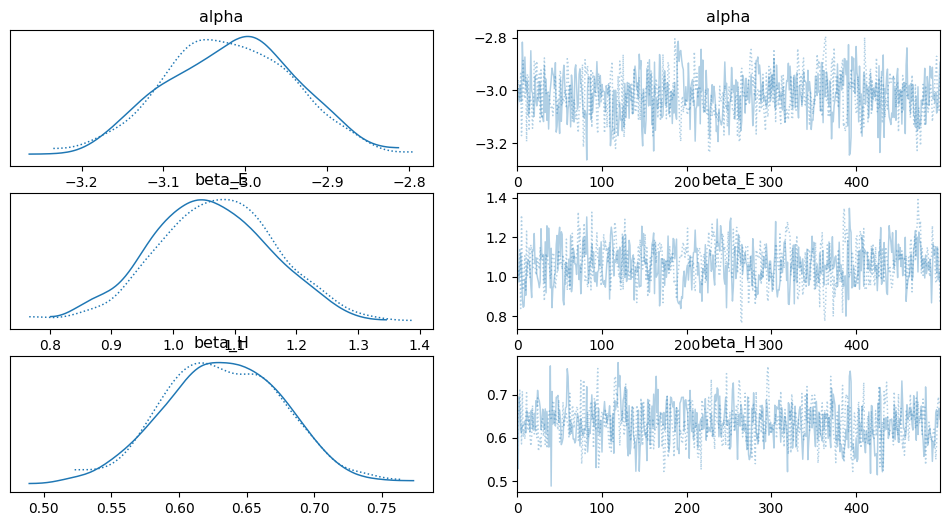

In [6]:
az.plot_trace(idata, var_names=["alpha", "beta_E", "beta_H"])
plt.show()

## 5) Posterior Predictive Check

Sampling: [Y_obs]


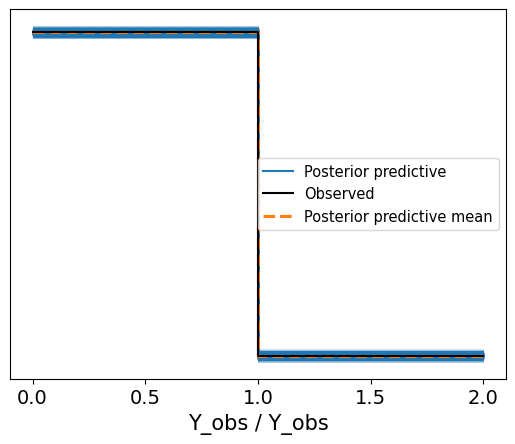

In [7]:
with model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

az.plot_ppc(ppc)
plt.show()

## 6) Posterior Ranking Metrics

In [8]:
# Posterior mean probability per building
p_post = idata.posterior["p"].mean(dim=("chain", "draw")).values

df["p_post_mean"] = p_post

# Rank by posterior mean
df["rank_post_mean"] = df["p_post_mean"].rank(ascending=False)

df.head()

,bldg_id,Y_damage_v1b,p_true,outcome_src,outcome_version,seed,alpha,beta_E,beta_H,E_hat,H_pluvial_v1_mm,E_std,H_std,p_post_mean,rank_post_mean
0,754660,0,0.040459,synthetic,v1b,42,-2.944439,1.0,0.6,0.352021,25.460167,0.420016,-1.076007,0.037347,3350.0
1,1089288,0,0.086687,synthetic,v1b,42,-2.944439,1.0,0.6,0.265809,25.757582,0.317658,0.425097,0.082421,1703.0
2,181051,0,0.064814,synthetic,v1b,42,-2.944439,1.0,0.6,0.452870,25.582821,0.539750,-0.456951,0.061151,2264.0
3,1060547,0,0.048044,synthetic,v1b,42,-2.944439,1.0,0.6,-0.326680,25.781500,-0.385785,0.545816,0.043955,3035.0
4,1027296,0,0.089988,synthetic,v1b,42,-2.944439,1.0,0.6,0.367937,25.731373,0.438912,0.292816,0.085913,1592.0


In [9]:
# Top-k membership probability
k = 1000  # top 1000 buildings

p_samples = idata.posterior["p"].stack(sample=("chain", "draw")).values

topk_counts = np.zeros(len(df))

for s in range(p_samples.shape[1]):
    idx = np.argsort(-p_samples[:, s])[:k]
    topk_counts[idx] += 1

topk_prob = topk_counts / p_samples.shape[1]

df["topk_prob"] = topk_prob

print("Top-k probability summary:")
df["topk_prob"].describe()

Top-k probability summary:


count    5000.000000
mean        0.200000
std         0.393293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: topk_prob, dtype: float64

In [11]:
# --- Save idata to disk ---

INF_DIR = REPO_ROOT / "outputs" / "rtm" / "inference"
INF_DIR.mkdir(parents=True, exist_ok=True)

idata_path = INF_DIR / "rtm_damage_v1b_logistic_idata.nc"
az.to_netcdf(idata, idata_path)

print("Saved idata to:", idata_path)

Saved idata to: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\inference\rtm_damage_v1b_logistic_idata.nc


In [12]:
import arviz as az
idata = az.from_netcdf(idata_path)
az.summary(idata, var_names=["alpha", "beta_E", "beta_H"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.019,0.082,-3.172,-2.872,0.004,0.003,523.0,575.0,1.00
beta_E,1.066,0.098,0.882,1.251,0.004,0.003,486.0,522.0,1.01
beta_H,0.634,0.045,0.550,0.717,0.002,0.001,642.0,664.0,1.01


## 7) Save Decision Metrics

In [10]:
decision_out = df[
    ["bldg_id", "p_post_mean", "rank_post_mean", "topk_prob"]
].copy()

out_path = OUT_DIR / "decision_metrics_v1b.parquet"
decision_out.to_parquet(out_path, index=False)

print("Saved:", out_path)

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\inference_v1b\decision_metrics_v1b.parquet
